# 2. Chebyshev Spectral Grid

In [1]:
import numpy as np
from scipy.special import erf

from scipy.linalg import inv
from scipy.fft import fft, ifft

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

The Chebyshev grid is used for polynomial interpolation, when the functions are not periodic. In this case, the basis functions are the Chebyshev polynomials. These polynomials are, however, very closely related to the Fourier basis, as they correspond to the real part of complex exponentials,

$$T_k \left[ cos(\theta) \right] = \cos(k \, \theta )\, .$$

Therefore, the Chebyshev grid is just the Fourier grid (with $\theta$ ranging from $0$ to $\pi$) on half the unit circle, but projected on the $x$-axis:

$$u_k(x) = T_k(x)\, , \quad k = 0, \dots, N,$$
$$x_j = \cos \left( \frac{2 \, \pi\,  j}{N} \right)\, , \quad j = 0, \dots, N.$$

In this case we include both the initial grid point ($\theta = 0$, $x = -1$) and the final point ($\theta = \pi$, $x = 1$), so the Chebyshev grid has $N+1$ points in total. The corresponding Fourier grid is a double copy of the Chebyshev grid, so it has $2N$ points (where $\theta$ varies from $0$ to $2\pi$). This fact will be used in Section 2.5 below.

In [2]:
N = 16

row = np.arange(N + 1)[:, None]
col = np.arange(N + 1)[None, :]

angular_spectral_grid = np.pi * row / N
spectral_grid         = np.cos(angular_spectral_grid)
angular_dense_grid    = np.linspace(0, np.pi, 1000)[:, None]
dense_grid            = np.cos(angular_dense_grid)

spectral_basis = np.cos(col * angular_spectral_grid)
dense_basis    = np.cos(col * angular_dense_grid)

## 2.1 Chebyshev polynomials and the Nyquist frequency

In this case, as the equivalent Fourier grid has $2N$ points, the basis only reaches up to the the Nyquist frequency, which is now $N$.

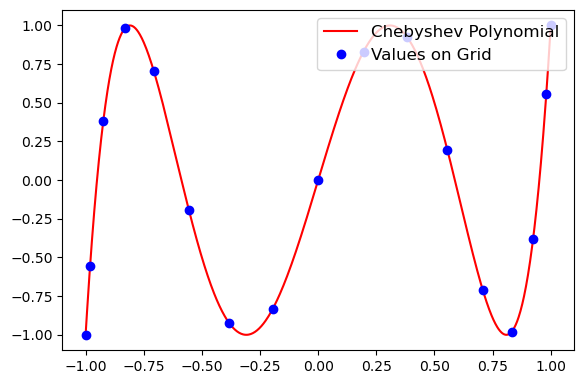

In [3]:
n = 5   # Try the Nyquist frequency n = N

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    dense_basis[:, n], 'r-', label = 'Chebyshev Polynomial')
ax.plot(spectral_grid, spectral_basis[:, n], 'bo',  label = 'Values on Grid')
ax.legend(loc = 'upper right')
ax.set_ylim(-1.1, 1.1)

plt.tight_layout()
################################################################################

## 2.2 Orthogonality

In the plot below, one can check that the specral basis matrix is equivalent to the upper left quadrant of (the real part of) the Fourier basis matrix from the previous notebook.

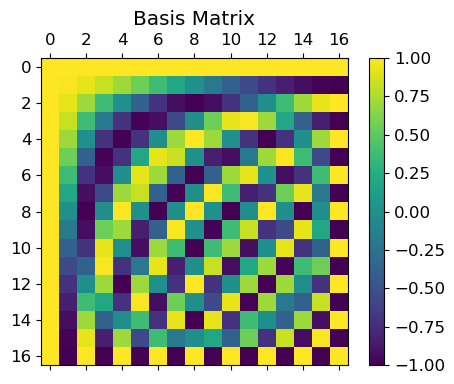

In [4]:
################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1, 1, figsize = (5, 4));
plt.rc('font', size = 12)

ax.set_title('Basis Matrix')
pt0 = ax.matshow(spectral_basis)
plt.colorbar(pt0, ax = ax)

plt.tight_layout()
################################################################################

The spectral basis matrix is "almost" idempotent. Its inverse is the element-wise multiplication of itself by some simple weights, encoded below in the matrix `c / N`.

True


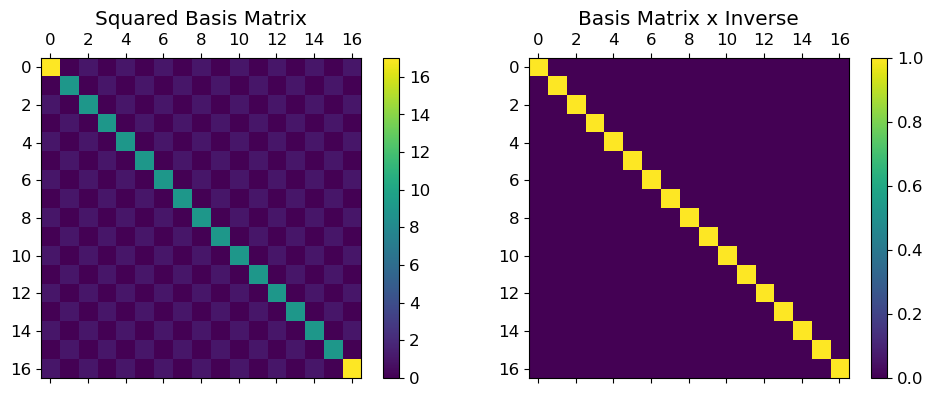

In [5]:
c = 1 + (col % N == 0)
c = 2 / (c.T @ c)
spectral_basis_inv = spectral_basis * (c / N)

print(np.allclose(spectral_basis_inv, inv(spectral_basis)))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Squared Basis Matrix')
pt0 = ax[0].matshow(spectral_basis @ spectral_basis)
plt.colorbar(pt0, ax = ax[0])

ax[1].set_title('Basis Matrix x Inverse')
pt1 = ax[1].matshow(spectral_basis @ spectral_basis_inv)
plt.colorbar(pt1, ax = ax[1])

plt.tight_layout()
################################################################################

## 2.3  The cardinal polynomials

The cardinal functions in this case are the Lagrange interpolating polynomials, defined as

$$\phi_i(x) = \prod_{\substack{j = 0\\j \neq i}}^N \frac{x - x_j}{x_i - x_j}\, .$$

In this case, the cardinals are independent of the parity of $N$, as the equivalent Fourier grid has $2N$ points, which is always even. 

True


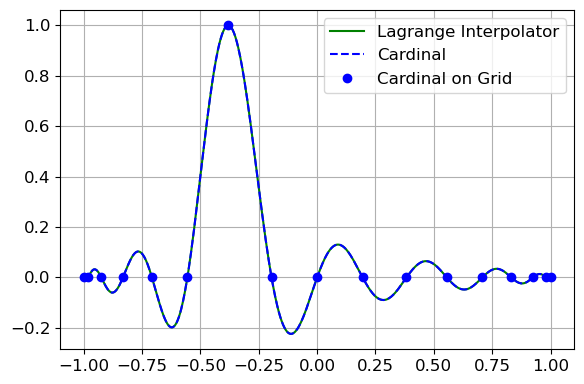

In [6]:
n = 10

def LagrangeInterpolator(x, j, spectral_grid):
    numerator = (x- spectral_grid[:, None])
    numerator[j, :] = 1
    denominator = (spectral_grid[j] - spectral_grid)
    denominator[j] = 1
    return np.prod(numerator, axis = 0) / np.prod(denominator)

spectral_cardinals = np.eye(N + 1)
dense_cardinals    = dense_basis @ spectral_basis_inv

print(np.allclose(LagrangeInterpolator(dense_grid, n, spectral_grid), dense_cardinals[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, LagrangeInterpolator(dense_grid, n, spectral_grid), color = 'green', label = 'Lagrange Interpolator')
ax.plot(dense_grid,    dense_cardinals[:, n], 'b--', label = 'Cardinal')
ax.plot(spectral_grid, spectral_cardinals[:, n], 'bo', label = 'Cardinal on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

The first derivative of the cardinals can be performed analytically by considering Leibniz product rule

$$\phi'_i(x) = \sum_{\substack{j = 0\\j \neq i}}^N \frac{\phi_i(x)}{x - x_j}\, ,$$

which will be used to construct the differentiation matrix.

True


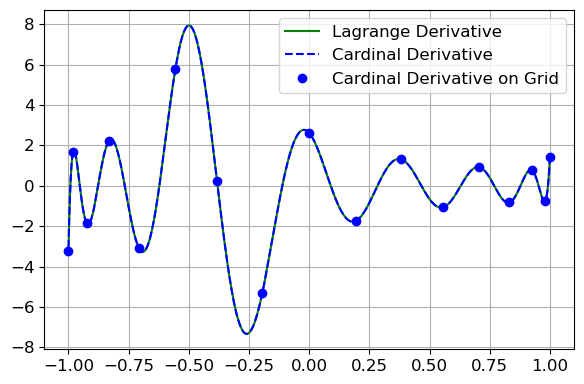

In [7]:
n = 10

def LagrangeDerivative(x, j, spectral_grid):
    epsilon = 1e-15
    numerator = (x + epsilon - spectral_grid[:, None])
    numerator[j, :] = 1
    denominator = (spectral_grid[j] - spectral_grid)
    denominator[j] = 1
    return np.prod(numerator, axis = 0) * (np.sum(1/numerator, axis = 0) - 1) / np.prod(denominator)

spectral_basis_diff = col * np.sin(col * angular_spectral_grid[1:-1]) / np.sin(angular_spectral_grid[1:-1]) 
dense_basis_diff    = col * np.sin(col * angular_dense_grid[1:-1])    / np.sin(angular_dense_grid[1:-1])
spectral_basis_diff = np.vstack([col**2, spectral_basis_diff, - (-1)**col * col**2])
dense_basis_diff    = np.vstack([col**2, dense_basis_diff   , - (-1)**col * col**2])

diff_matrix          = spectral_basis_diff @ spectral_basis_inv
dense_cardinals_diff = dense_basis_diff @ spectral_basis_inv

print(np.allclose(LagrangeDerivative(dense_grid, n, spectral_grid), dense_cardinals_diff[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, LagrangeDerivative(dense_grid, n, spectral_grid), color = 'green', label = 'Lagrange Derivative')
ax.plot(dense_grid, dense_cardinals_diff[:, n].real, 'b--', label = 'Cardinal Derivative')
ax.plot(spectral_grid, diff_matrix[:, n].real, 'bo',   label = 'Cardinal Derivative on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

## 2.4 Chebyshev Differentiation Matrices and Interpolation

The coefficients of the differentiation matrces, can be computed analytically by a series of tricks, which are encapsulated in the function `ChebyshevD(N)` below. In this case, the take second derivative matrix to be the squared first derivative.

In [8]:
def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x  = np.cos(np.pi * row / N)
    c  = ((1 + (col % N == 0)) * (-1) ** col).T
    X  = np.ones(N + 1) * x
    dX = X - X.T
    D  = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

x, D1, D2 = ChebyshevD(N)
np.allclose(D1, diff_matrix)

True

We can check that the deifferentiation matrices give the correct results on the Gaussian curve $f(x) = e^{-5x^2}$. Again, the matrix `dense_cardinals` can be used to get the interpolated functions outside the grid to make continuous plots.

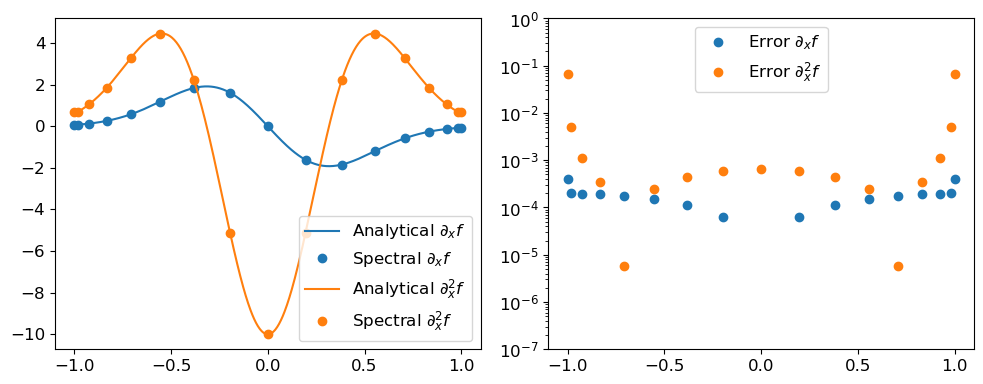

In [9]:
f   = np.exp( -5 * x**2 )
df  = - 10 * x * f
ddf = 10 * (10 * x**2 - 1) * f

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ df,  label = r'Analytical $\partial_x f$',   color = colors[0])
ax[0].plot(x, D1 @ f, 'o', label = r'Spectral $\partial_x f$', color = colors[0])
ax[0].plot(dense_grid, dense_cardinals.real @ ddf, label = r'Analytical $\partial^2_x f$', color = colors[1])
ax[0].plot(x, D2 @ f, 'o', label = r'Spectral $\partial^2_x f$', color = colors[1])
ax[0].legend(loc = 'lower right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(D1 @ f - df),  'o', label = r'Error $\partial_x f$', color = colors[0])
ax[1].plot(x, np.abs(D2 @ f - ddf), 'o', label = r'Error $\partial^2_x f$', color = colors[1])
ax[1].legend(loc = 'upper center')
ax[1].set_ylim(1e-7, 1)

plt.tight_layout()
################################################################################

## 2.5 Chebyshev FFT Differentiation

As in the Fourier case, we can use FFT to compute derivatives on the Chebyshev grid. To do so, we need to construct its full equivalent Fourier grid, as a double copy of the Chebyshev grid. If a function takes the values 

$$f_\text{Chebyshev} = (f_0, f_1, f_2, \dots, f_{N-2}, f_{N-1}, f_N)^T$$

on the Chebyshev grid ($N+1$ values in total), then it will take the values 

$$f_\text{Fourier} = (f_0, f_1, f_2 \dots, f_{N-2}, f_{N-1}, f_N, f_{N-1}, f_{N-2}, \dots, f_2, f_1)^T$$

on the equivalent Fourier grid ($2N$ values in total). The equivalence is plotted in the figures below:

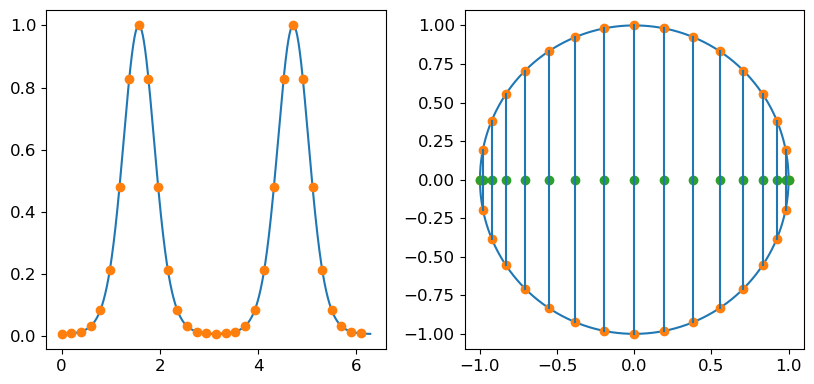

In [10]:
f  = np.exp( -5 * x**2 )
df = -10 * x * np.exp( -5 * x**2 )

long_f             = np.vstack([f, f[-2:0:-1, :]])
long_spectral_grid = np.vstack([angular_spectral_grid, angular_spectral_grid[1:-1, :] + np.pi])
long_dense_f       = np.vstack([(dense_cardinals @ f), (dense_cardinals @ f)[-2:0:-1, :]])
long_dense_grid    = np.vstack([angular_dense_grid, angular_dense_grid[1:-1, :] + np.pi])

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (8.3, 4));
plt.rc('font', size = 12)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax[0].plot(long_dense_grid, long_dense_f)
ax[0].plot(long_spectral_grid, long_f, 'o')

ax[1].plot(np.cos(long_dense_grid), np.sin(long_dense_grid))
ax[1].plot(np.cos(long_spectral_grid), np.sin(long_spectral_grid), 'o')
ax[1].plot(spectral_grid, np.zeros(N+1), 'o', color = colors[2])
[ax[1].plot([line, line], [-np.sqrt(1-line**2), np.sqrt(1-line**2)], color = colors[0]) for line in spectral_grid]

plt.tight_layout()
################################################################################

Once we have the (twice repeated) function on the Fourier grid, we can apply the standard FFT differentiation. Then we must convert back to the Chebyshev grid by using the Jacobian

$$x = \cos(\theta)\, , \quad \frac{d\theta}{dx} = - \frac{1}{\sqrt{1 - x^2}}\, .$$

The derivatives at the points with $x = \pm 1$ are 0/0 indeterminates, so they must be handled separately.


The frequencies we are considering are: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15   0 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1].
Notice we have removed the asymetric Nyquist mode.



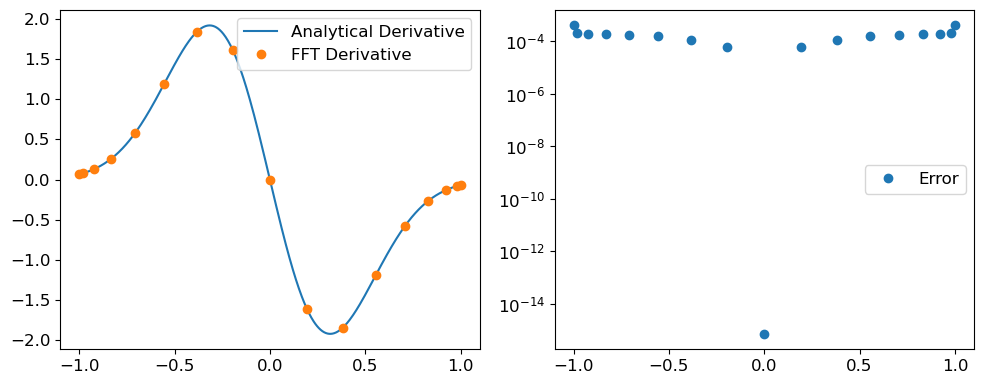

In [11]:
def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

freqs    = aliased_index(np.arange(2 * N), 2 * N) 
freqs[N] = 0    #This is equivalent to Trefethen's trick in page 78.

long_fft  = fft(long_f.flatten()).real 
long_ifft = ifft(1j * freqs * long_fft).real

FFT_df      = np.zeros(N + 1)
ind         = np.arange(N)
FFT_df[1:N] = - long_ifft[1:N] / np.sqrt(1 - x[1:-1, 0].flatten()**2)
FFT_df[0]   = np.sum(ind**2 * long_fft[:N]) / N + 0.5 * N * long_fft[N]
FFT_df[N]   = np.sum((-1)**(ind + 1) * ind**2 * long_fft[:N]) / N + 0.5 * (-1)**(N+1) * N * long_fft[N]
    
print(f'\nThe frequencies we are considering are: {freqs}.')
print(f'Notice we have removed the asymetric Nyquist mode.\n')

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals @ df, label = 'Analytical Derivative')
ax[0].plot(x, FFT_df, 'o', label = 'FFT Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(FFT_df - df.flatten()), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 2.6 The Clenshaw-Curtis quadrature and integration

The elements of the FFT can be related to the coefficients $a_n$ of the function in the spectral basis of Chebyshev polynomials

$$f(x) \approx \sum_{n=0}^N a_n \, T_n(x)\, .$$

In [12]:
c      = N * (1 + (row % N == 0))
fft_an = long_fft[:N+1, None] / c

np.allclose(fft_an, spectral_basis_inv @ f)

True

The coefficients $a_n$ can then be used to integrate the function over the domain $[-1,1]$, which is known as the Clenshaw-Curtis quadrature

$$\int_{-1}^{+1} f(x) \, dx \approx \sum_{\text{even } n} \frac{2a_n}{1 - n^2}\, .$$

In [13]:
CorrectIntegral    = 0.79142461922102708410
FFT_ClenshawCurtis = np.sum(2 * fft_an[::2] / (1 - row[::2]**2))

np.isclose(CorrectIntegral, FFT_ClenshawCurtis)

True

The function `ClenshawCurtisWeights(N)` computes directly the weights $w_i$ of each Chebyshev grid point (in direct space) to the Clenshaw-Curtis integral, without the need of performing any FFT, so we can do

$$\int_{-1}^{+1} f(x) \, dx \approx \sum_{i = 0}^N w_i \, f(x_i)\, .$$

In [14]:
def ClenshawCurtisWeights(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    th  = np.pi * row / N
    w   = (col % N == 0) / (N**2 - (N%2 == 0))
    v = 1 - np.sum(2 * np.cos(2 * col[:, 1:(N+1)//2] * th[1:-1, :]) / (4 * col[:, 1:(N+1)//2]**2 - 1), axis = 1)[:, None]
    v = v - (N%2 == 0) * np.cos(N * th[1:-1, :]) / (N**2 - 1)
    w[:, 1:-1] = 2*v.T/N
    return w


clenshaw_curtis_weights = ClenshawCurtisWeights(N)
Weighted_ClenshawCurtis = clenshaw_curtis_weights @ f

np.allclose(CorrectIntegral, Weighted_ClenshawCurtis)

True

If we need indefinite integrals, or antiderivatives, we can construct the matrix `spectral_basis_int`, whose columns are the antiderivatives of the Chebyshev polynomials. These can be obtained, for instance, from the relation

$$\int T_n(x) \, dx = \frac12 \left( \frac{T_{n+1}(x)}{n+1} -  \frac{T_{n-1}(x)}{n-1} \right) \, , \quad (\text{for } n \geq 2)\, .$$

We choose the integration constants such that the antiderivative vanishes at $x = -1$. From this, we obtain the integration matrix `int_matrix`, whose columns are the antiderivatives of the cardinal polynomials. We can check that the first row of the integration matrix (corresponding to $x=1$) coincides with the Clenshaw-Curtis weights computed before.

True


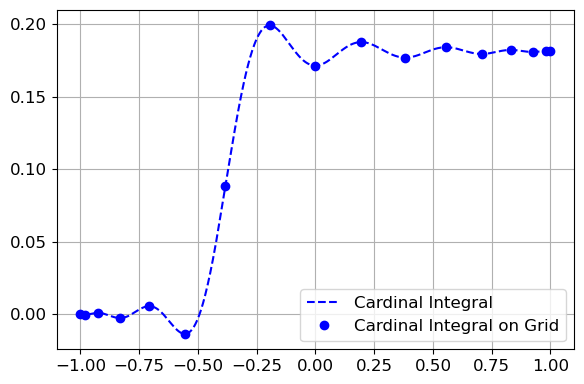

In [15]:
n = 10

scol = col[:, 2:]

spectral_basis_int  = 0.5 * np.cos((scol + 1) * angular_spectral_grid) / (scol + 1) - \
                      0.5 * np.cos((scol - 1) * angular_spectral_grid) / (scol - 1)
spectral_basis_int  = np.hstack([spectral_grid, spectral_grid**2 / 2, spectral_basis_int])
spectral_basis_int -= spectral_basis_int[[-1], :]

dense_basis_int  = 0.5 * np.cos((scol + 1) * angular_dense_grid) / (scol + 1) - \
                   0.5 * np.cos((scol - 1) * angular_dense_grid) / (scol - 1)
dense_basis_int  = np.hstack([dense_grid, dense_grid**2 / 2, dense_basis_int])
dense_basis_int -= dense_basis_int[[-1], :]

int_matrix          = spectral_basis_int @ spectral_basis_inv
dense_cardinals_int = dense_basis_int @ spectral_basis_inv

print(np.allclose(int_matrix[0, :], clenshaw_curtis_weights))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, dense_cardinals_int[:, n].real, 'b--', label = 'Cardinal Integral')
ax.plot(spectral_grid, int_matrix[:, n].real, 'bo', label = 'Cardinal Integral on Grid')
ax.legend(loc = 'lower right')
ax.grid()

plt.tight_layout()
################################################################################

Finally, we can check that the integration matrix produces the correct antiderivative of our test function.

True


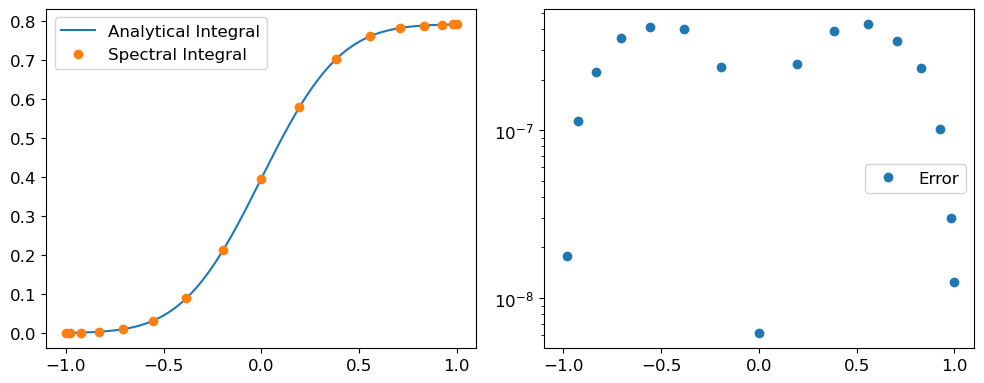

In [16]:
f  = np.exp( -5 * x**2 )
int_f  = 0.5 * np.sqrt(np.pi / 5) * erf(np.sqrt(5) * x)
int_f -= int_f[-1]

print(np.allclose(int_f[0], CorrectIntegral))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ int_f, label = 'Analytical Integral')
ax[0].plot(x, int_matrix @ f, 'o', label = 'Spectral Integral')
ax[0].legend(loc = 'upper left')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(int_matrix @ f - int_f), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################